ValueError: zero-size array to reduction operation minimum which has no identity

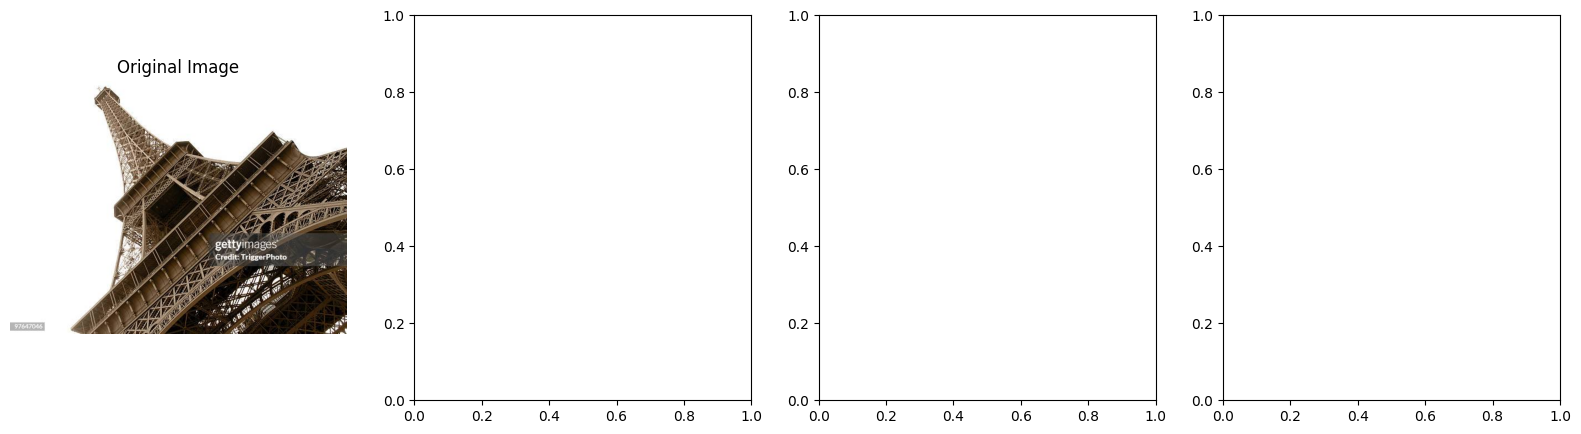

In [5]:
import torch
import clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAMPlusPlus, LayerCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 啟用異常偵測（幫助找出 inplace 問題，可移除）
torch.autograd.set_detect_anomaly(True)

# 裝置設定
device = "cuda" if torch.cuda.is_available() else "cpu"

# 載入 CLIP 模型（強制 fp32，避免 HalfTensor 問題）
model, preprocess = clip.load("ViT-B/32", device=device)
model = model.float()  # 確保 fp32
model.eval()

# 載入圖片（請替換成你的圖片路徑）
image_path = "query_image.jpg"  # 例如一張貓的照片
raw_image = Image.open(image_path).convert("RGB")
image_input = preprocess(raw_image).unsqueeze(0).to(device)

# 文字提示（類別）
texts = ["a photo of a cat", "a photo of a dog", "a photo of a car"]
text_tokens = clip.tokenize(texts).to(device)

# 預計算文字特徵（non-inplace 正規化）
with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_norm = text_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_norm  # non-inplace

# Wrapper 讓 CLIP 輸出類似分類的 logits（修正 inplace）
class CLIPWrapper(torch.nn.Module):
    def __init__(self, clip_model, text_features):
        super().__init__()
        self.clip_model = clip_model
        self.text_features = text_features
    
    def forward(self, image):
        image_features = self.clip_model.encode_image(image)
        image_norm = image_features.norm(dim=-1, keepdim=True)
        image_features = image_features / image_norm  # non-inplace
        logit_scale = self.clip_model.logit_scale.exp()
        logits = logit_scale * image_features @ self.text_features.t()
        return logits

wrapper_model = CLIPWrapper(model, text_features).to(device)

# 目標層（ViT 的最後一層正規化）
target_layers = [model.visual.transformer.resblocks[-1].ln_1]

# ViT 專用的 reshape 函數（移除 cls token 並轉成特徵圖）
def reshape_transform(tensor):
    batch_size, _, channels = tensor.shape
    tensor = tensor[:, 1:, :]  # 移除 cls token
    height = width = int(np.sqrt(tensor.shape[1]))
    tensor = tensor.reshape(batch_size, height, width, channels)
    tensor = tensor.permute(0, 3, 1, 2)  # 轉成 (B, C, H, W)
    return tensor

# 定義不同 CAM 方法
cam_methods = {
    "GradCAM++": GradCAMPlusPlus(model=wrapper_model, target_layers=target_layers, reshape_transform=reshape_transform),
    "LayerCAM": LayerCAM(model=wrapper_model, target_layers=target_layers, reshape_transform=reshape_transform),
    "EigenCAM": EigenCAM(model=wrapper_model, target_layers=target_layers, reshape_transform=reshape_transform)
}

# 選擇要可視化的文字類別（例如第 0 個：cat）
target_category_index = 0
targets = [ClassifierOutputTarget(target_category_index)]

# 轉成 numpy 供顯示（正規化到 0-1）
img_rgb = np.array(raw_image) / 255.0
img_rgb = np.float32(img_rgb)

# 產生並顯示各個熱力圖
fig, axs = plt.subplots(1, len(cam_methods) + 1, figsize=(20, 5))
axs[0].imshow(img_rgb)
axs[0].set_title("Original Image")
axs[0].axis("off")

for i, (method_name, cam) in enumerate(cam_methods.items()):
    grayscale_cam = cam(input_tensor=image_input, targets=targets)[0, :]
    visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
    axs[i+1].imshow(visualization)
    axs[i+1].set_title(f"{method_name} (for '{texts[target_category_index]}')")
    axs[i+1].axis("off")

plt.show()

# 若要儲存圖片
# cv2.imwrite(f"{method_name}_cam.jpg", visualization[:, :, ::-1] * 255)